In [2]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import Hybrid_nn
import torch
from torch import nn
import data
import pennylane as qml
import embedding

## 0. Getting Started

In [3]:
feature_reduction = 'PCA16'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', '2', feature_reduction=feature_reduction, classes=classes)
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_train, X0_train = [], []
for i in range(len(X_train)):
    if Y_train[i] == 1:
        X1_train.append(X_train[i])
    else:
        X0_train.append(X_train[i])

X1_test, X0_test = torch.tensor(X1_test), torch.tensor(X0_test)
X1_train, X0_train = torch.tensor(X1_train), torch.tensor(X0_train)

2022-12-18 23:16:41.696661: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 23:16:41.697267: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.
/opt/anaconda3/envs/QC/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835196/work/torch/csrc/utils/tensor_new.cpp:233.)
  app.launch_new_instance()


## 1. Calculate the distance before and after pre-training QEmbedding

In [4]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev, interface="torch")
def distance_circuit1(inputs): 
    qml.AmplitudeEmbedding(inputs, wires=range(4), normalize=True)
    return qml.density_matrix(wires=range(4))

class Distance(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1_distance = qml.qnn.TorchLayer(distance_circuit1, weight_shapes={})
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32,32),
            nn.ReLU(),
            nn.Linear(32,16)
        )
    
    def forward(self, x1, x0, measure, after):
        if after == True:
            x1 = self.linear_relu_stack(x1)
            x0 = self.linear_relu_stack(x0)
        rhos1 = self.qlayer1_distance(x1)
        rhos0 = self.qlayer1_distance(x0)
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0

        if measure == "Trace":
            eigvals = torch.linalg.eigvals(rho_diff)
            return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))
        elif measure == "Hilbert-Schmidt":
            return 0.5 * torch.real(torch.trace(rho_diff @ rho_diff))

PATH = "/Users/tak/Github/QEmbedding/Results/earlystop 10 experiments/experiment1/Model Amplitude/Model_Amplitude.pt"
Model = Distance()
Model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

Trace Distance Before Training

In [5]:
Trace_Distance_Before_traindata = Model(X1_train, X0_train, 'Trace', False)
Trace_Distance_Before_testdata = Model(X1_test, X0_test, 'Trace', False)

Trace_Distance_After_traindata = Model(X1_train, X0_train, 'Trace', True)
Trace_Distance_After_testdata = Model(X1_test, X0_test, 'Trace', True)

LB_Before_traindata = 0.5 * (1 - Trace_Distance_Before_traindata)
LB_Before_testdata = 0.5 * (1 - Trace_Distance_Before_testdata)
LB_After_traindata = 0.5 * (1 - Trace_Distance_After_traindata)
LB_After_testdata = 0.5 * (1 - Trace_Distance_After_testdata)

print(f"(Train data) Trace Distance Before: {Trace_Distance_Before_traindata}")
print(f"(Train data) Trace Distance After: {Trace_Distance_After_traindata}")
print(f"(Test data) Trace Distance Before: {Trace_Distance_Before_testdata}")
print(f"(Test data) Trace Distance After: {Trace_Distance_After_testdata}")
print("\n")
print(f"(Train data) Lower Bound Before: {LB_Before_traindata}")
print(f"(Train data) Lower Bound After: {LB_After_traindata}")


/opt/anaconda3/envs/QC/lib/python3.7/site-packages/pennylane/qnn/torch.py:328: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835196/work/aten/src/ATen/native/Copy.cpp:250.)
  return self.qnode(**kwargs).type(x.dtype)


(Train data) Trace Distance Before: 0.5372605323791504
(Train data) Trace Distance After: 0.9467379450798035
(Test data) Trace Distance Before: 0.5428512692451477
(Test data) Trace Distance After: 0.9528061151504517


(Train data) Lower Bound Before: 0.2313697338104248
(Train data) Lower Bound After: 0.026631027460098267


## 3. Train QCNN with / without QEmbedding pre-training

In [6]:
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class x_transform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x.detach().numpy()

model = x_transform().to(device)
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

In [8]:
def statepreparation(x, Trained):
    if Trained:
        x = model(torch.tensor(x))
    qml.AmplitudeEmbedding(x, wires=range(4), normalize=True)

def U(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

def QCNN_four(params):
    param1 = params[0:15]
    param2 = params[15:30]
    U(param1, wires=[0, 1])
    U(param1, wires=[2, 3])
    U(param1, wires=[1, 2])
    U(param1, wires=[3, 0])
    U(param2, wires=[0, 2])


@qml.qnode(dev)
def QCNN_classifier(params, x, Trained):
    statepreparation(x, Trained)
    QCNN_four(params)
    return qml.expval(qml.PauliZ(2))

def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)

def cost(weights, X_batch, Y_batch, Trained):
    preds = [QCNN_classifier(weights, x, Trained) for x in X_batch]
    return Linear_Loss(Y_batch, preds)

steps = 800
learning_rate = 0.01
batch_size = 128
def circuit_training(X_train, Y_train, Trained):

    weights = np.random.random(30, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, Trained),
                                                     weights)
        loss_history.append(cost_new)
        if it % 50 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return weights, loss_history

In [9]:
Loss_histories_not_trained, Loss_histories_trained = [], []
parameters_not_trained, parameters_trained = [], []
for i in range(5):
    params_not_trained, loss_not_trained = circuit_training(X_train, Y_train, False)
    params_trained, loss_trained = circuit_training(X_train, Y_train, True)
    
    Loss_histories_not_trained.append(loss_not_trained)
    Loss_histories_trained.append(loss_trained)
    parameters_not_trained.append(params_not_trained)
    parameters_trained.append(params_trained)

Loss_histories_not_trained, Loss_histories_trained = np.array(Loss_histories_not_trained), np.array(Loss_histories_trained)
Not_trained_mean, Not_trained_std = Loss_histories_not_trained.mean(axis=0), Loss_histories_not_trained.std(axis=0)
Trained_mean, Trained_std = Loss_histories_trained.mean(axis=0), Loss_histories_trained.std(axis=0)

/opt/anaconda3/envs/QC/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


iteration:  0  cost:  0.44573738083853554
iteration:  50  cost:  0.3512527398482045
iteration:  100  cost:  0.31546783984860605
iteration:  150  cost:  0.3228185728380233
iteration:  200  cost:  0.3046611738288069
iteration:  250  cost:  0.29026354152740386
iteration:  300  cost:  0.2940833032779734
iteration:  350  cost:  0.29049888505296295
iteration:  400  cost:  0.2738427842837682
iteration:  450  cost:  0.2808137978046128
iteration:  500  cost:  0.2710097275775111
iteration:  550  cost:  0.29696411930088645
iteration:  600  cost:  0.2703434755388759
iteration:  650  cost:  0.2663465088763547
iteration:  700  cost:  0.25121963227900124
iteration:  750  cost:  0.26356340619153695
iteration:  0  cost:  0.5063271772226896
iteration:  50  cost:  0.21632403821984503
iteration:  100  cost:  0.1911358579311324
iteration:  150  cost:  0.15273867814904393
iteration:  200  cost:  0.10447390468418051
iteration:  250  cost:  0.12648921652780457
iteration:  300  cost:  0.09806391562271094
itera

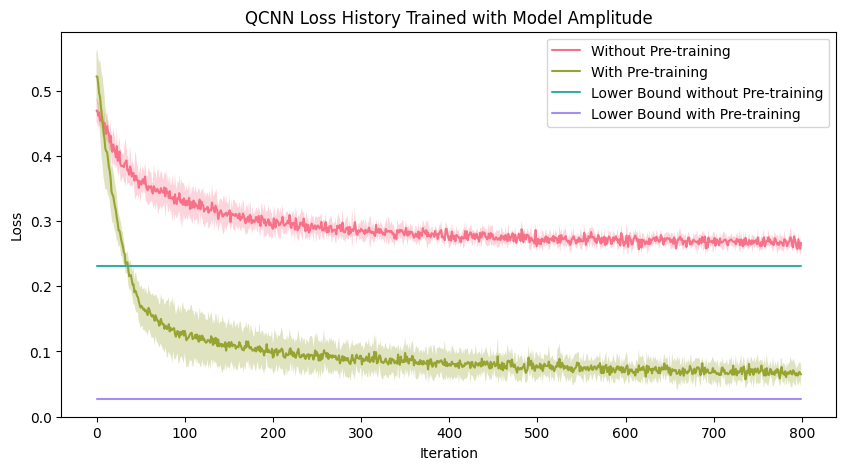

In [14]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 4)
with sns.axes_style("darkgrid"):
    ax.plot(range(len(Not_trained_mean)), Not_trained_mean, label="Without Pre-training", c=clrs[0])
    ax.fill_between(range(len(Not_trained_mean)), Not_trained_mean-Not_trained_std, Not_trained_mean+Not_trained_std, alpha=0.3,facecolor=clrs[0])

    ax.plot(range(len(Trained_mean)), Trained_mean, label="With Pre-training", c=clrs[1])
    ax.fill_between(range(len(Trained_mean)), Trained_mean-Trained_std, Trained_mean+Trained_std, alpha=0.3,facecolor=clrs[1])

    ax.plot(range(800), np.ones(800) * LB_Before_traindata.detach().numpy(), label="Lower Bound without Pre-training", c=clrs[2])
    ax.plot(range(800), np.ones(800) * LB_After_traindata.detach().numpy(), label="Lower Bound with Pre-training", c=clrs[3])

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("QCNN Loss History Trained with Model Amplitude")
ax.legend()

In [15]:


f = open('/Users/tak/Github/QEmbedding/Results/earlystop 10 experiments/Analysis/Model Amplitude/QCNN_loss_history.txt', 'w')
for i in range(5):
    f.write(f'Loss History Trained {i + 1}')
    f.write('\n')
    f.write(str(Loss_histories_trained[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Loss History Not Trained {i + 1}')
    f.write('\n')
    f.write(str(Loss_histories_not_trained[i]))
    f.write('\n')
f.close()

In [17]:
f = open('/Users/tak/Github/QEmbedding/Results/earlystop 10 experiments/Analysis/Model Amplitude/QCNN_trained_params.txt', 'w')
for i in range(5):
    f.write(f'Parameters Trained {i + 1}')
    f.write('\n')
    f.write(str(parameters_trained[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Parameters Not Trained {i + 1}')
    f.write('\n')
    f.write(str(parameters_not_trained[i]))
    f.write('\n')
f.close()